In [1]:
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
import os
import scipy.sparse as sp
import yaml

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [2]:
os.chdir('../')

In [112]:
# Define base parameters
#emb_p = '/home/xlv0877/proj_home/dl/resources/genePT_embeddings/GenePT_gene_embedding_ada_text.pickle'
emb_p = '/home/xlv0877/proj_home/dl/resources/genePT_embeddings/GenePT_gene_protein_embedding_model_3_text.pickle'
adata_p = '/home/xlv0877/proj_home/ExPert/results/merge/6db565012b360b93/perturb_metaset.h5ad'
run_dir = os.path.dirname(adata_p)
#adata_p = '/home/xlv0877/proj_home/dl/data/studies/iPSC_KOFL_Mali/PaperPerturbations.h5ad'

In [131]:
# Extract information on target gene perturbations

adata = sc.read(adata_p)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [132]:
# Load data
with open(emb_p, 'rb') as file:
    emb = pickle.load(file)

In [133]:
# Isolate gene targets
gene_targets = adata.obs.perturbation.unique()
# Filter for genes that are available in embedding
available_targets = set(gene_targets).intersection(set(emb.keys()))
print(f'Found {len(available_targets)}/{len(gene_targets)} perturbations in resource')

Found 2677/2736 perturbations in resource


In [264]:
# Filter embedding for available genes
t_emb = {k:v for k,v in emb.items() if k in available_targets}
# Convert to dataframe
t_emb = pd.DataFrame(t_emb).T
# Add control and unknown label to embedding
#ctrl_row = np.zeros((1, t_emb.shape[1]))
#ctrl_row = np.random.normal(loc=0, scale=1e-3, size=(1, t_emb.shape[1]))
ctrl_row = np.matrix(t_emb.mean(axis=0))
#unknown_row = np.zeros((1, t_emb.shape[1]))
#unknown_row = np.random.normal(loc=0, scale=1e-3, size=(1, t_emb.shape[1]))
unknown_row = np.matrix(t_emb.mean(axis=0))
zero_rows = pd.DataFrame(np.concatenate([ctrl_row, unknown_row], axis=0), index=['control', 'unknown'])
t_emb = pd.concat([t_emb, zero_rows], axis=0)

In [135]:
# Create a map of embedding index and gene
gene_emb_idx_map = pd.DataFrame(t_emb.index.factorize()).T
gene_emb_idx_map.columns = ['emb_idx', 'gene']

In [265]:
# Scale embedding by factor
scaling_factor = 10
emb_a = (t_emb * scaling_factor)

In [266]:
# Add interpolate values for knockdown (-1) and activation (1)
emb_i = emb_a * -1
emb_i.index = 'neg;' + emb_i.index.astype(str)
emb_a.index = 'pos;' + emb_a.index.astype(str)
class_emb = pd.concat([emb_a, emb_i])

In [267]:
pca = sc.pp.pca(class_emb)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [268]:
import umap
import numpy as np
import matplotlib.pyplot as plt


# Fit UMAP on PCA-reduced data
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean')
umap_embedding = reducer.fit_transform(pca)  # (n_samples, 2)

In [269]:
pl_df = pd.DataFrame(
    {
        'UMAP-1': umap_embedding[:,0], 'UMAP-2': umap_embedding[:,1],
        'perturbation': class_emb.index.str.split(';').str[1].values,
        'perturbation type': class_emb.index.str.split(';').str[0].values,
        'cls_label': class_emb.index.values
    }
)
pl_df['ctrl'] = pl_df.perturbation=='control'

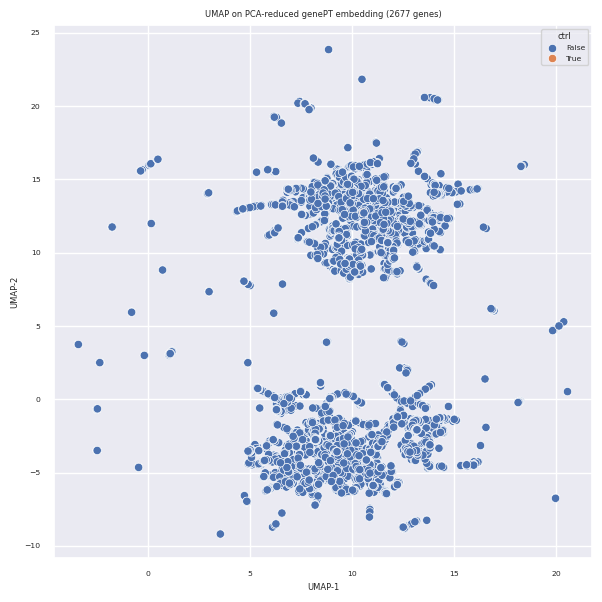

In [270]:
# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(pl_df, x='UMAP-1', y='UMAP-2', hue='ctrl')
plt.title(f"UMAP on PCA-reduced genePT embedding ({len(available_targets)} genes)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

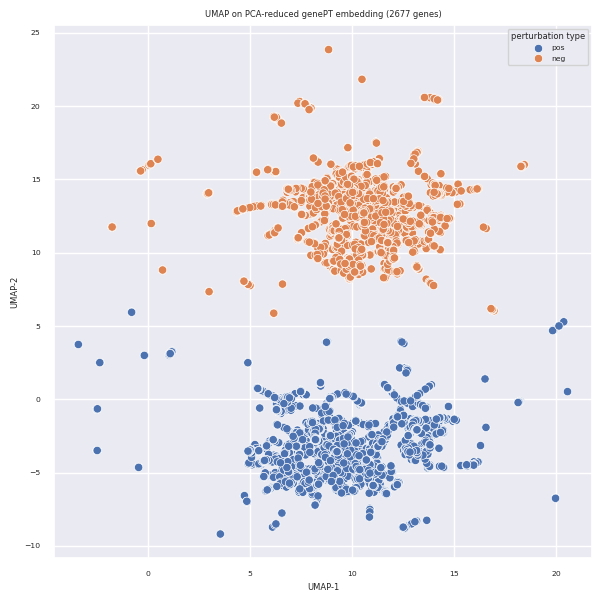

In [271]:
# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(pl_df, x='UMAP-1', y='UMAP-2', hue='perturbation type')
plt.title(f"UMAP on PCA-reduced genePT embedding ({len(available_targets)} genes)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [272]:
# Split perturbation type into positive and negative
adata.obs['perturbation_direction'] = adata.obs['perturbation_type'].str.startswith('CRISPRa').apply(lambda x: 'pos' if x else 'neg')
# Create perturbation labels
cls_labels = (adata.obs['perturbation_direction'].astype(str) + ';' + adata.obs['perturbation'].astype(str)).unique()
# Add embedding to adata
class_emb.columns = 'dim_' + class_emb.columns.astype(str)
adata.uns['cls_embedding'] = class_emb.loc[list(set(cls_labels).intersection(set(class_emb.index))),:]

In [273]:
# Save adata
adata_o = os.path.join(os.path.dirname(adata_p), 'adata_w_cls_emb_prot.h5ad')
adata.write_h5ad(adata_o)

In [146]:
#adata = sc.read(os.path.join(os.path.dirname(adata_p), 'adata_w_cls_emb.h5ad'), backed='r')
test_adata = sc.read('data/model_set.h5ad', backed='r')

In [297]:
#test_emb = adata.uns['cls_embedding'].loc[adata.obs.cls_label.unique()]
test_emb = class_emb.loc[test_adata.obs.cls_label.unique().sort_values()]
test_emb = test_emb[~test_emb.index.str.endswith('control')]

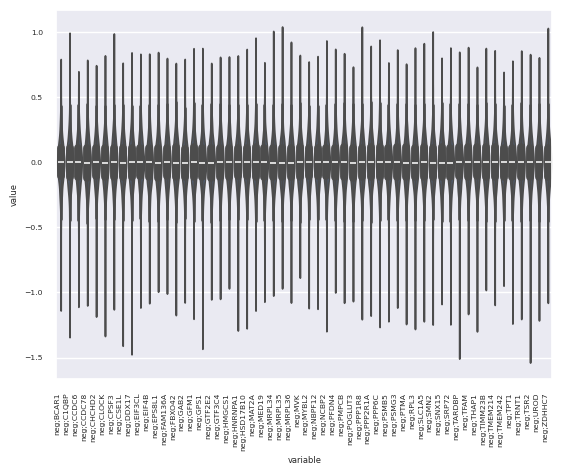

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.violinplot(test_emb.T.melt(), x='variable', y='value')
plt.xticks(rotation=90, ha='right')
plt.show()

In [299]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(test_emb)

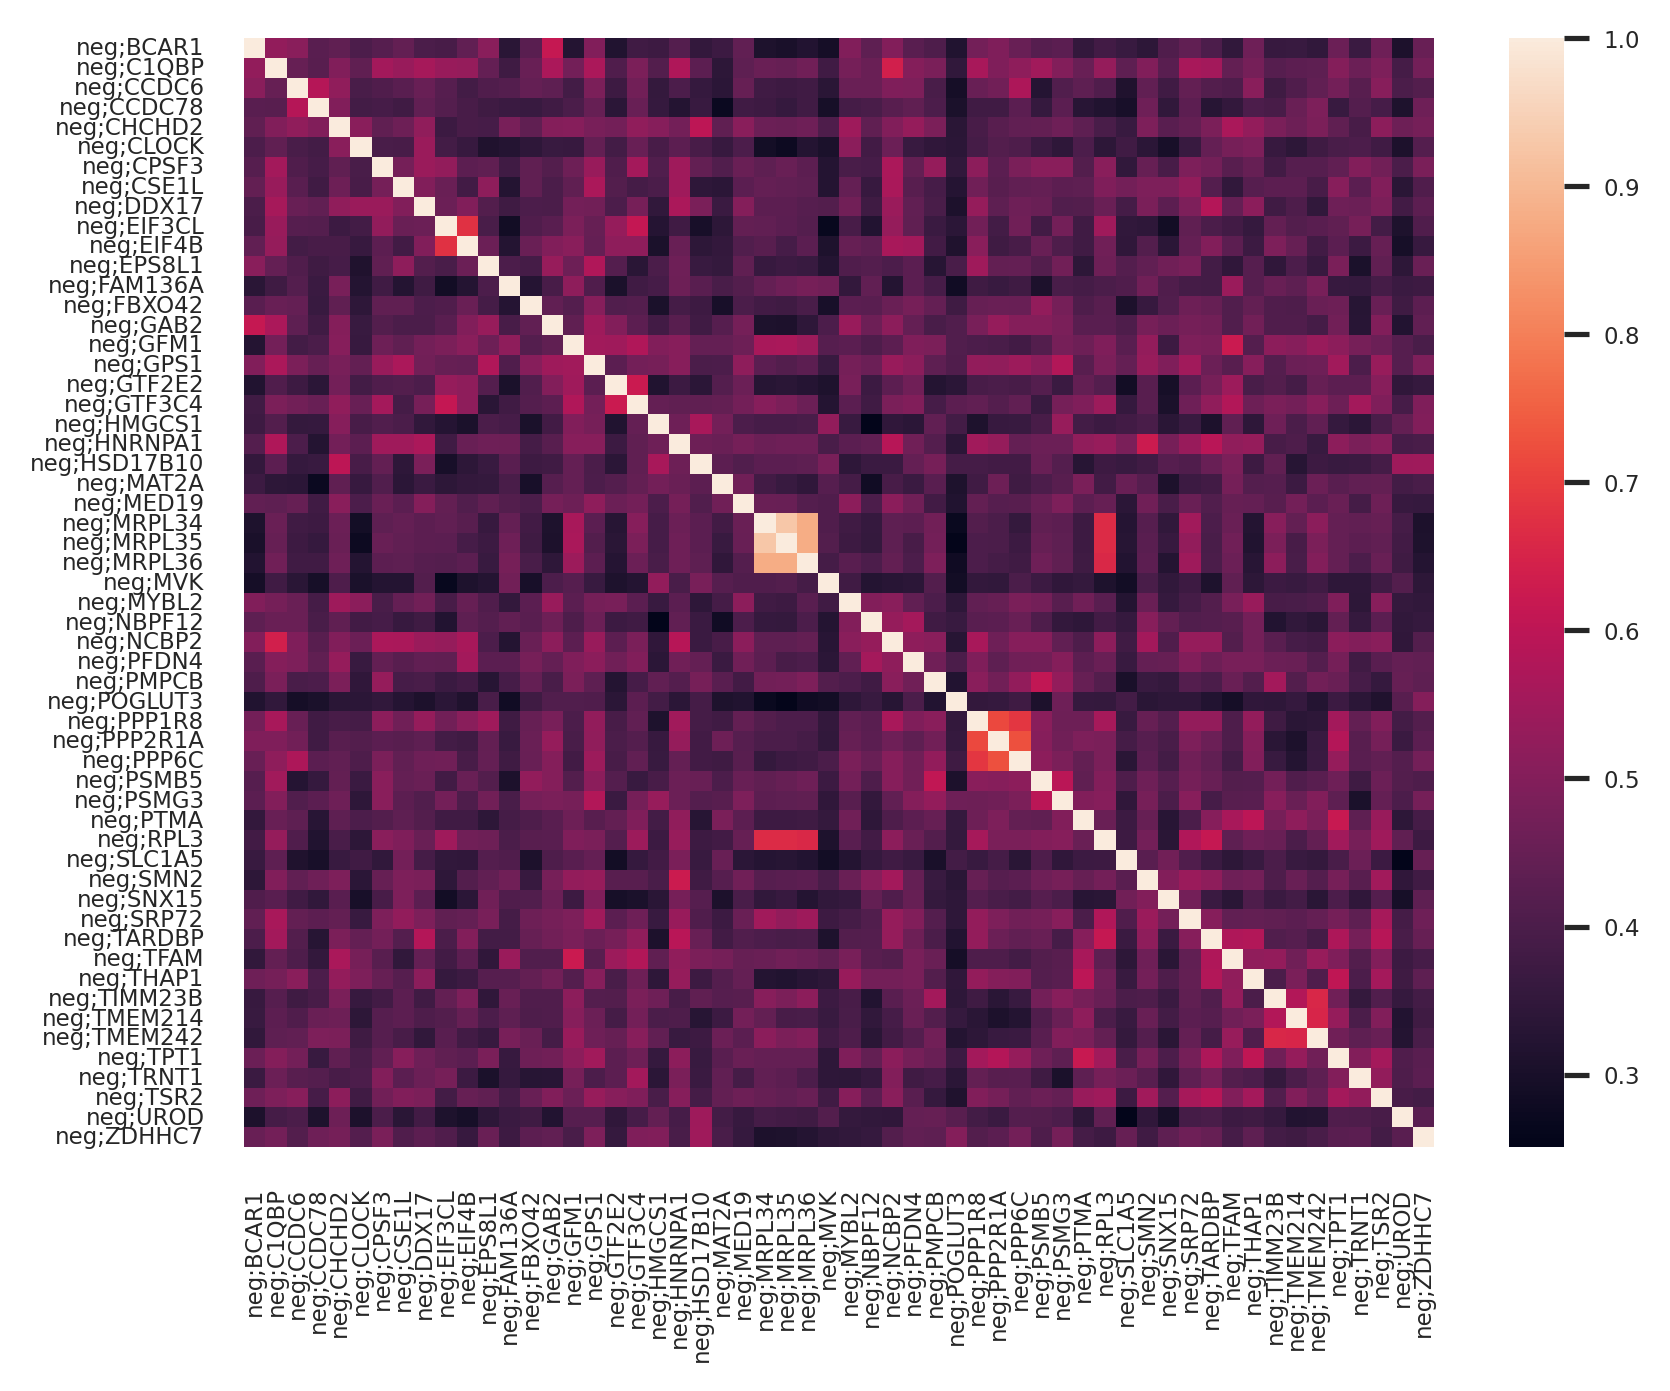

In [300]:
# Check internal correlation
fig = plt.figure(dpi=300)
sns.set_theme(font_scale=.5)
sns.heatmap(cos_sim, xticklabels=test_emb.index, yticklabels=test_emb.index)
plt.show()

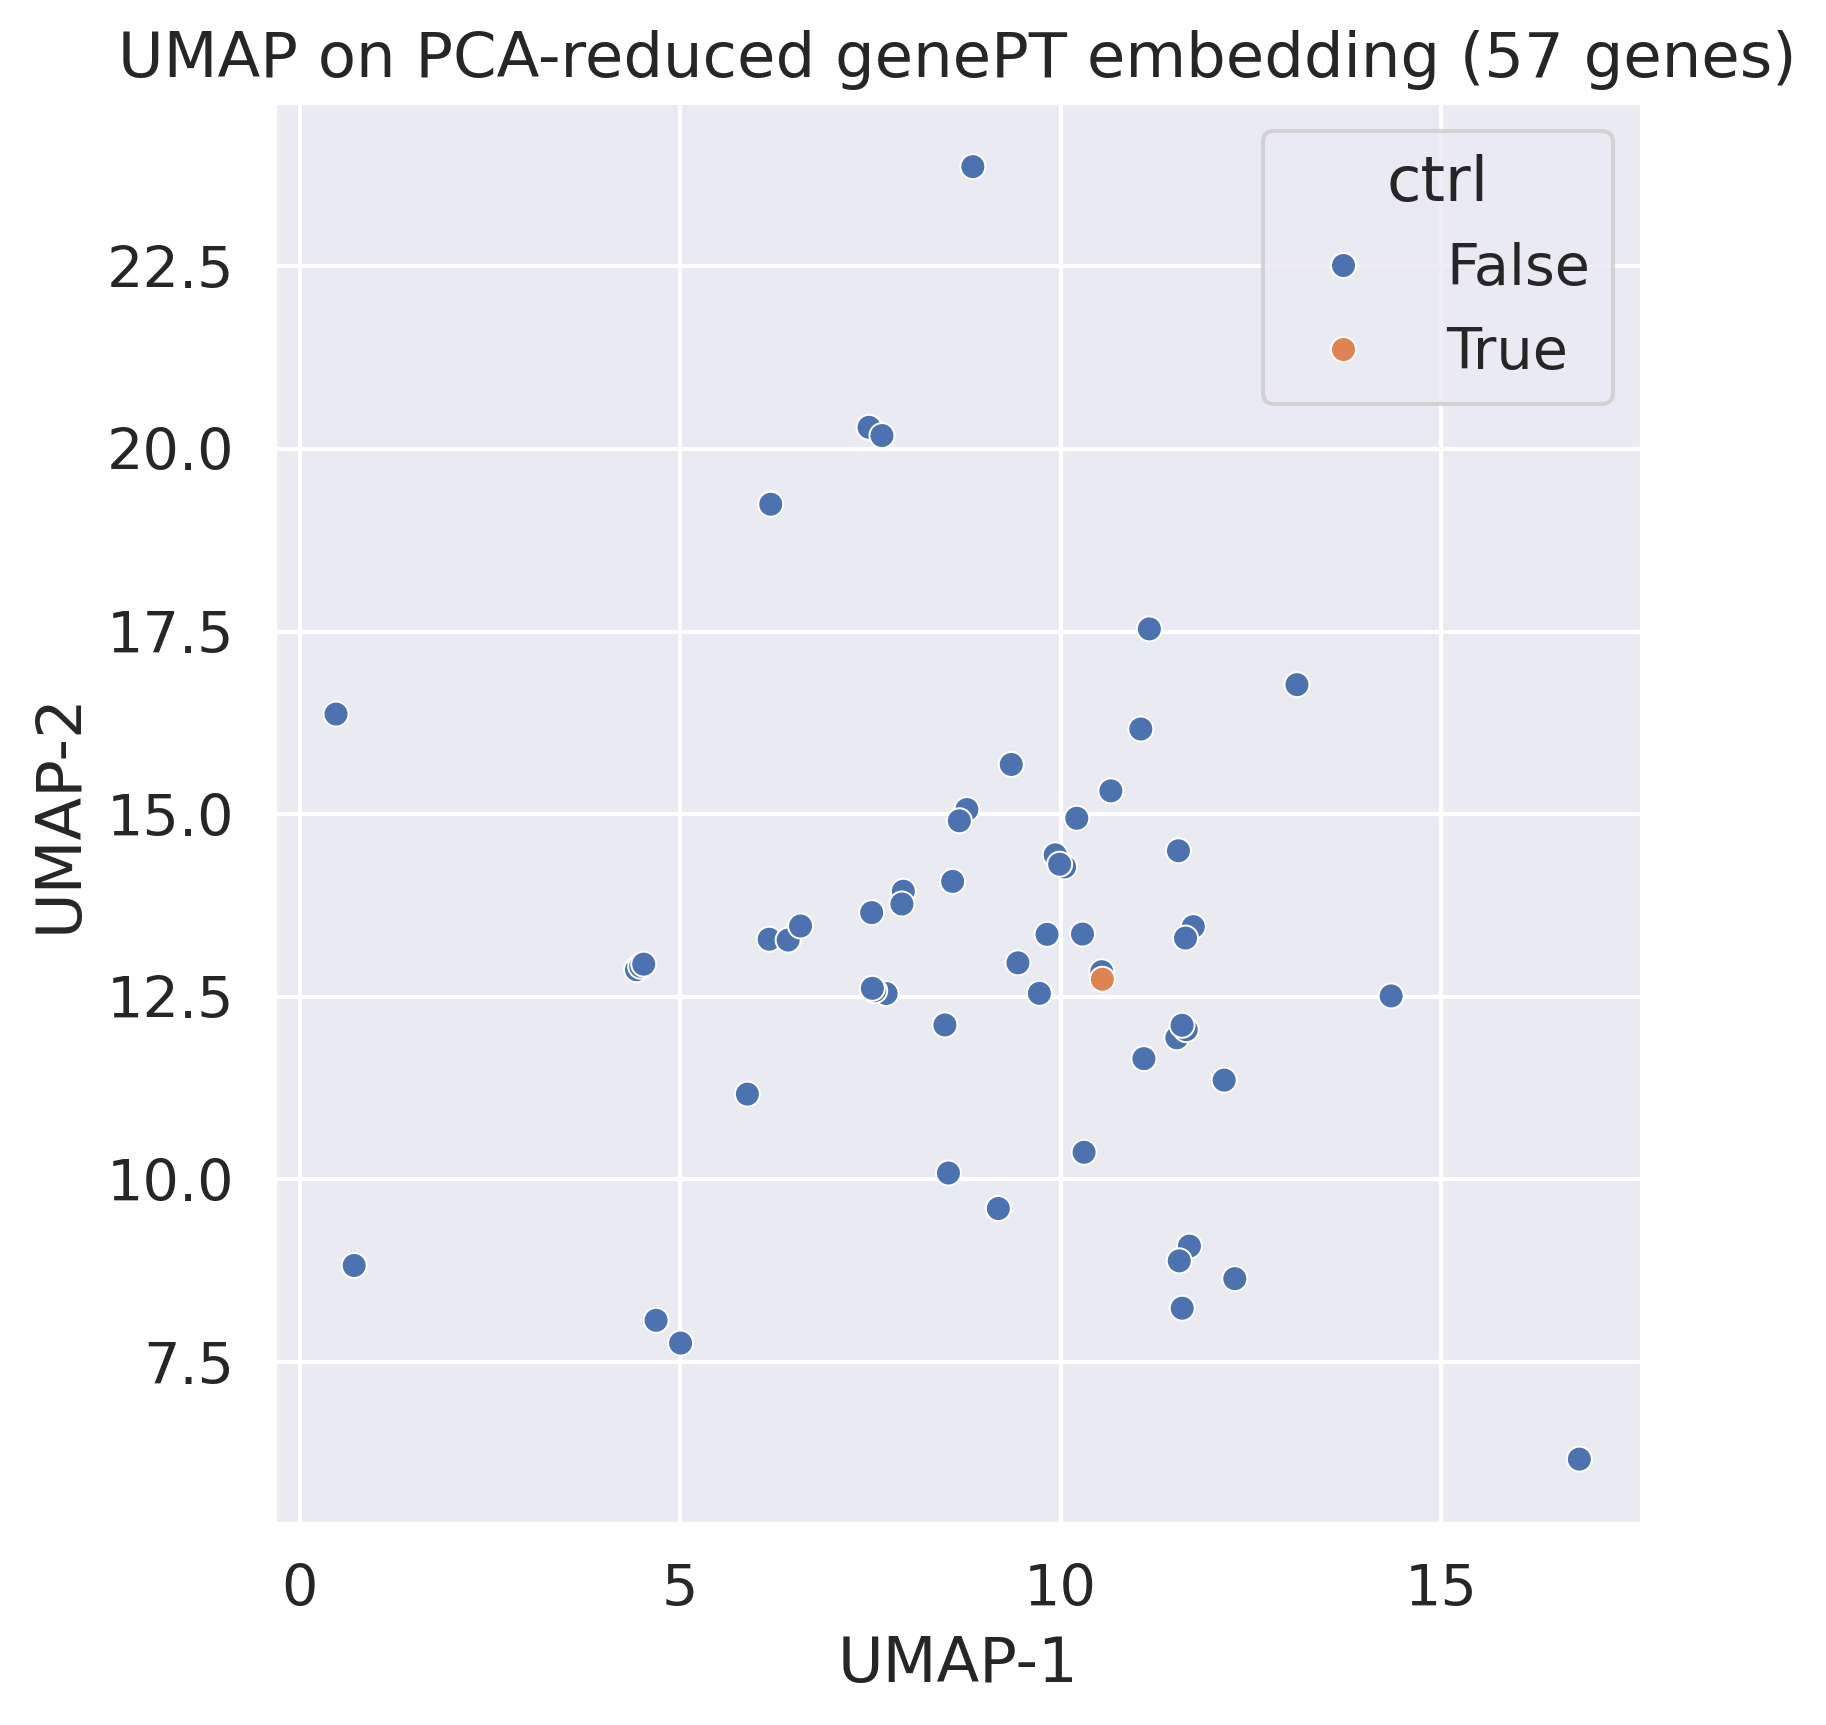

In [285]:
# Plot
test_df = pl_df[pl_df['cls_label'].isin(test_emb.index)]
plt.figure(figsize=(6, 6), dpi=300)
sns.scatterplot(test_df, x='UMAP-1', y='UMAP-2', hue='ctrl')
plt.title(f"UMAP on PCA-reduced genePT embedding ({test_df.shape[0]} genes)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

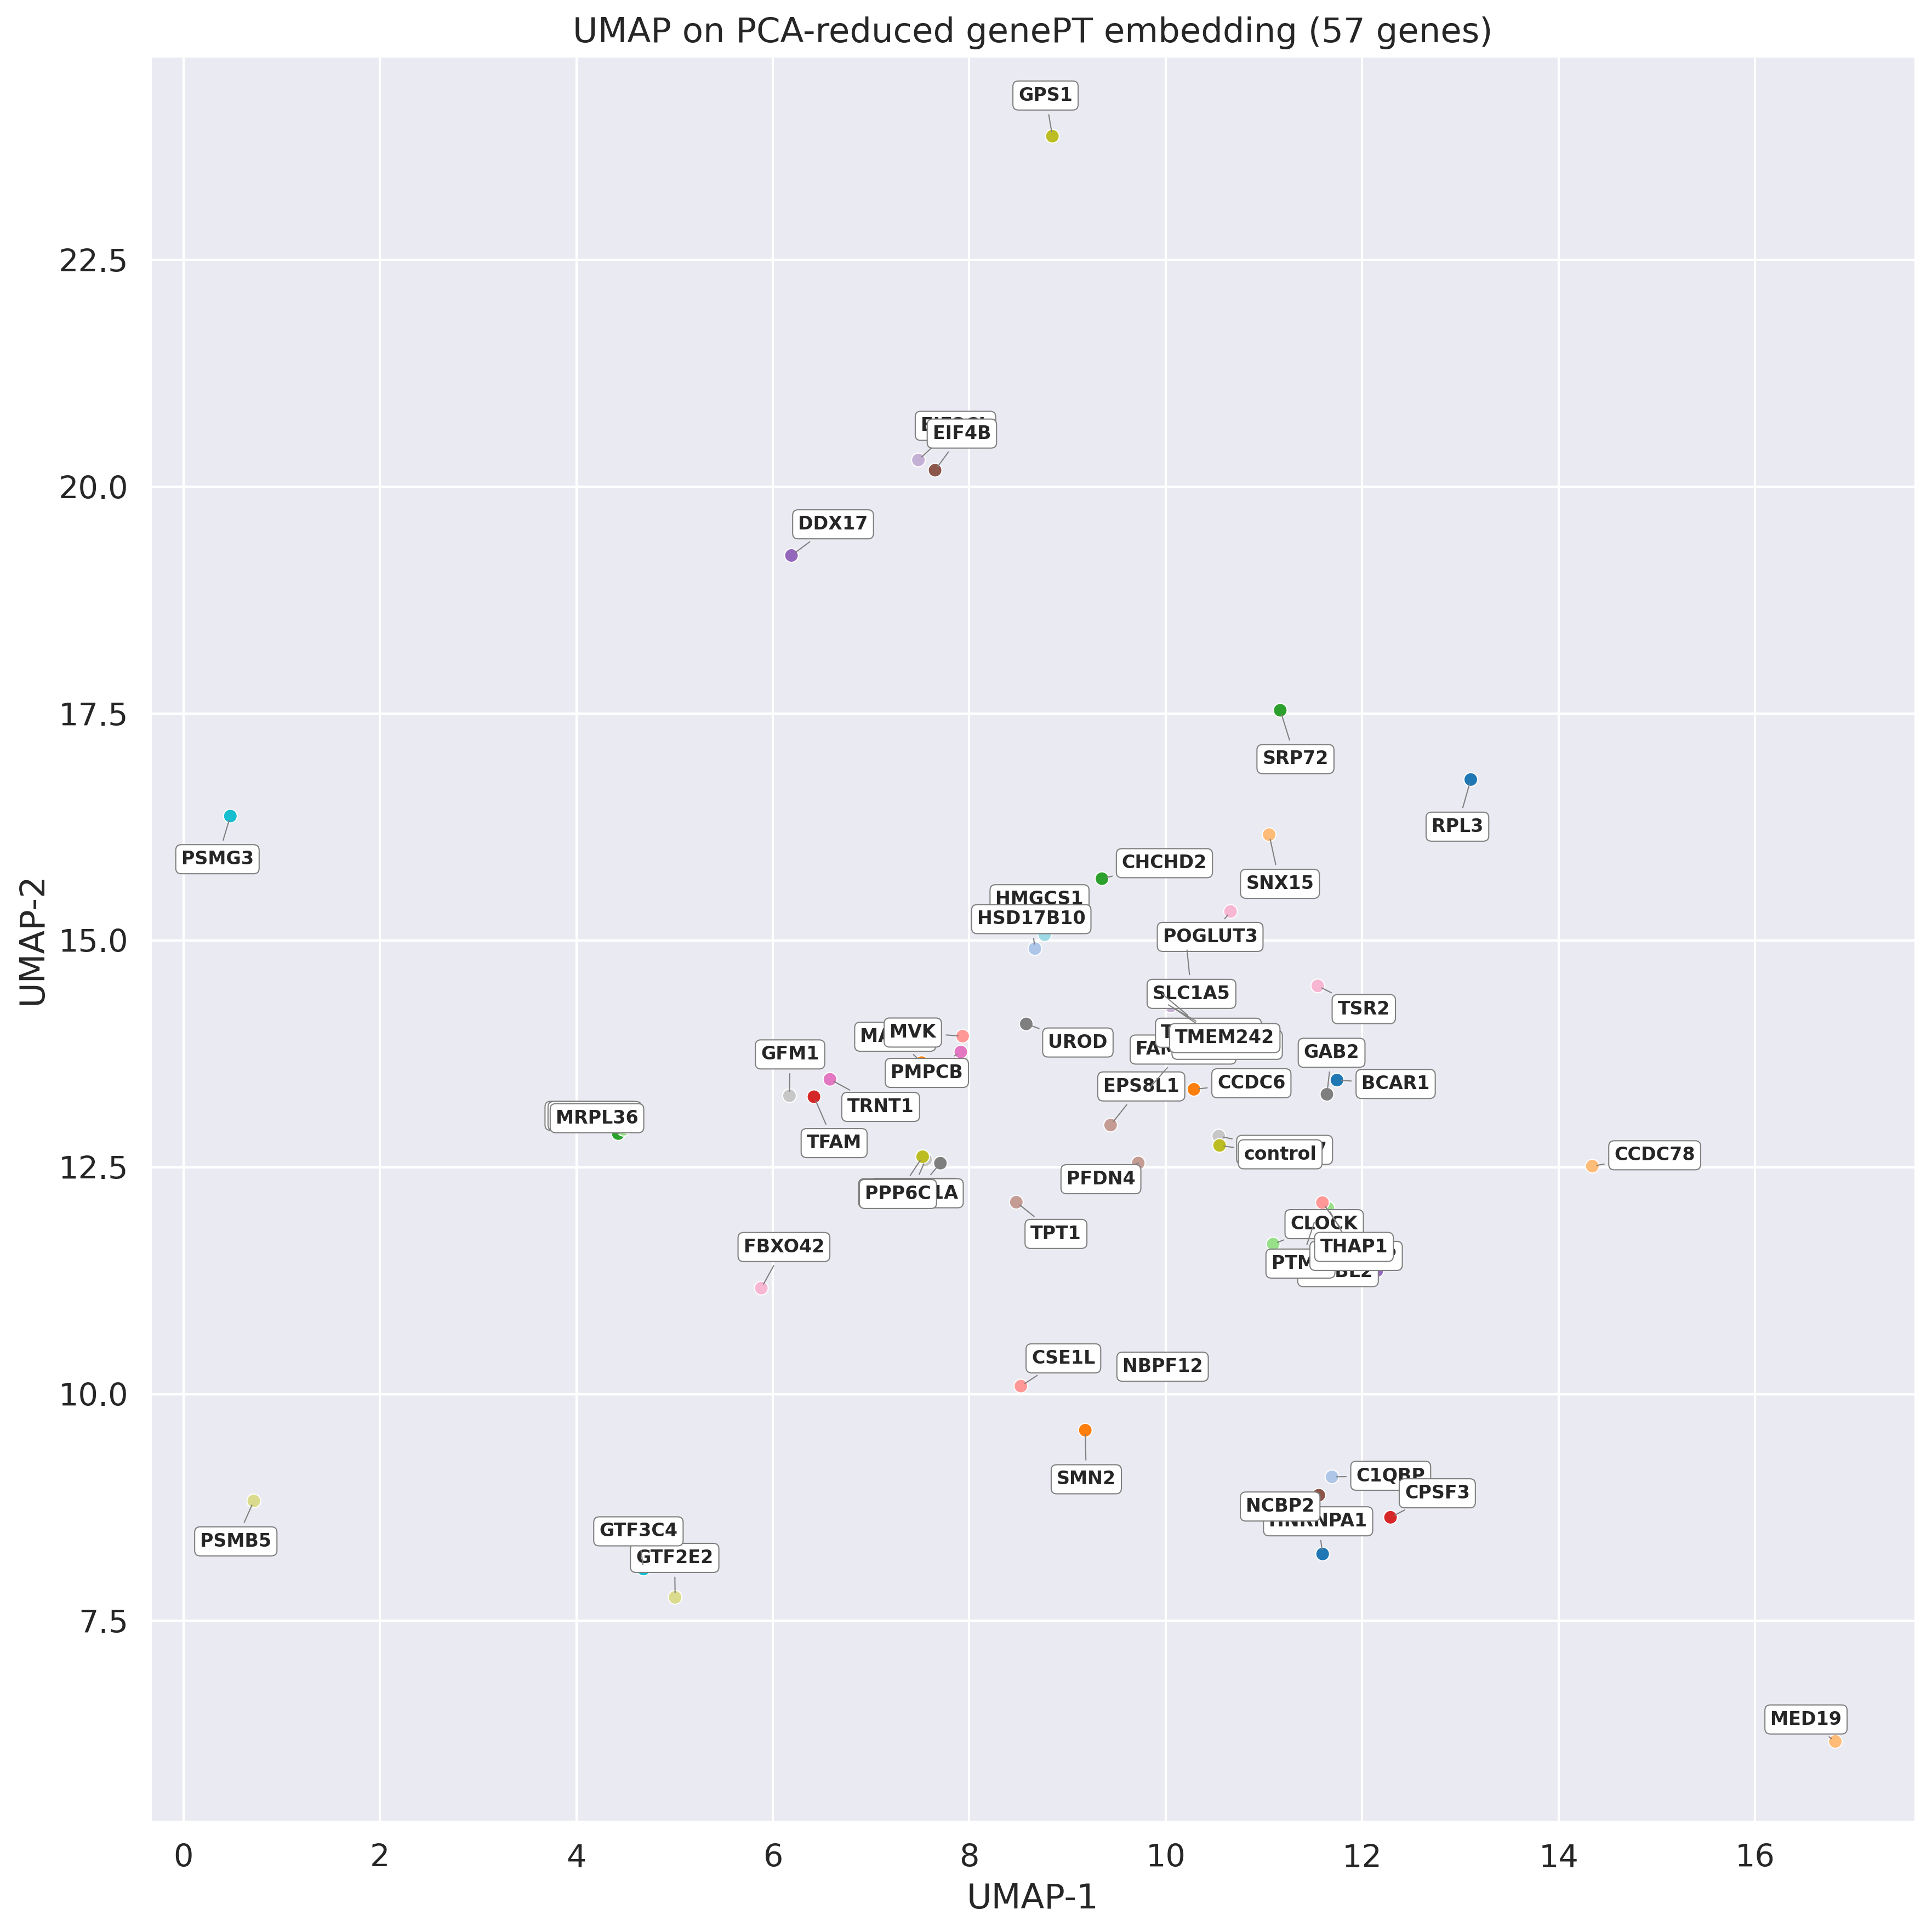

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the scatterplot
plt.figure(figsize=(12, 12), dpi=300)
sns.set_theme(font_scale=1.25)
ax = sns.scatterplot(data=test_df, x='UMAP-1', y='UMAP-2', hue='perturbation', palette='tab20')
plt.title(f"UMAP on PCA-reduced genePT embedding ({test_df.shape[0]} genes)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)

# Remove the legend
ax.legend_.remove()

# Compute centroids per class
centroids = test_df.groupby('perturbation')[['UMAP-1', 'UMAP-2']].mean()

# Create small offset vectors in a circular pattern to space labels
angles = np.linspace(0, 2 * np.pi, len(centroids), endpoint=False)
offsets = np.column_stack((np.cos(angles), np.sin(angles))) * 0.5  # scale for visibility

# Add one label per class at the centroid, offset by a small amount, with arrow
for i, (label, (x, y)) in enumerate(centroids.iterrows()):
    dx, dy = offsets[i]
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x - 0.25 + dx, y - 0.1 + dy),
        textcoords='data',
        fontsize=8,
        weight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5),
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )

plt.tight_layout()
plt.show()

In [305]:
# Inspect latent
latent = sc.read('/home/xlv0877/proj_home/dl/models/run1/rl+kl+c/lightning_logs/version_0/latent.h5ad')

In [311]:
mat = latent.X

In [397]:
target_classes = latent.obs._scvi_labels.value_counts().sort_values(ascending=False)[10:14].index

In [411]:
target_idx = np.random.permutation(latent[latent.obs._scvi_labels.isin(target_classes)]
 .obs.groupby('_scvi_labels')
 .apply(lambda x: x.sample(10).index.tolist())
 .explode().tolist())

In [478]:
b_latent = latent[target_idx].copy()
y = b_latent.obs._scvi_labels.values
idx = np.arange(b_latent.shape[0])
batch = b_latent.X

In [455]:
mask = (y[:,None] == y)

<Axes: >

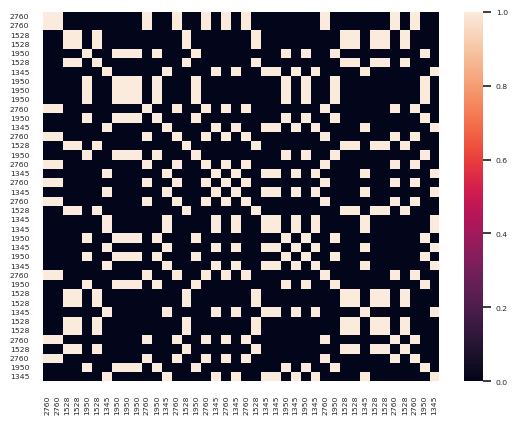

In [456]:
import seaborn as sns

sns.heatmap(mask, xticklabels=y, yticklabels=y)

In [457]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(batch)

In [458]:
# Calculate distances for same classes
s = D*mask**2

In [540]:
mask.shape

(40, 40)

In [459]:
# Calculate distances for different classes
m = 20
d = ((m-D)*(1-mask))**2

<Axes: >

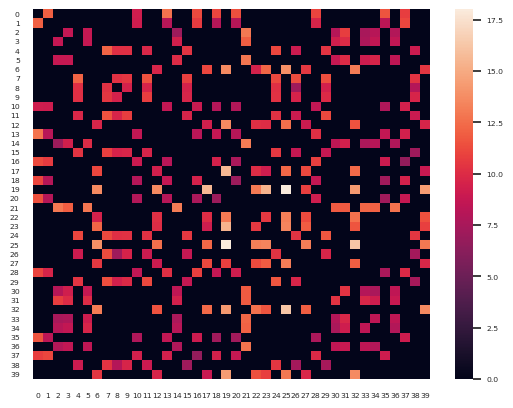

In [479]:
sns.heatmap(s, xticklabels=idx, yticklabels=idx)

<Axes: >

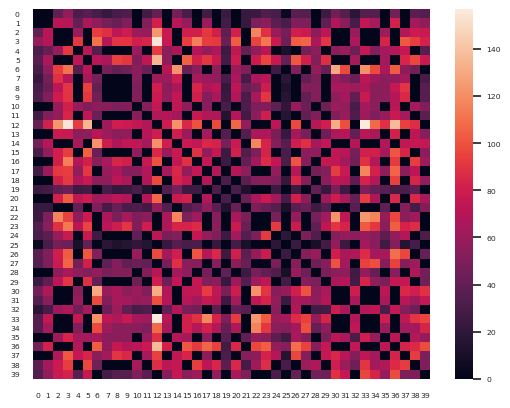

In [512]:
sns.heatmap(d, xticklabels=idx, yticklabels=idx)

In [516]:
beta = 0.5

39535.6732514348

In [537]:
l_df = []
for beta in np.arange(0, 1.1, 0.1):
    l = (1-beta)*s.sum() 
    r = beta*d.sum()
    t = l + r
    l_df.append([l, r, t, beta])
l_df = pd.DataFrame(l_df, columns=['s', 'd', 't', 'b'])

In [538]:
l_df = l_df.melt(id_vars='b')

<Axes: xlabel='b', ylabel='value'>

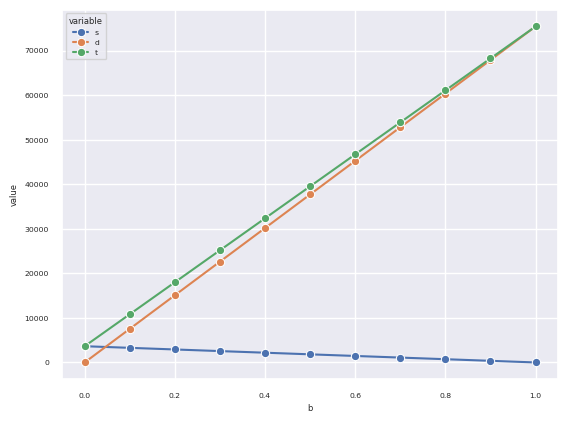

In [539]:
sns.lineplot(l_df, x='b', y='value', hue='variable', marker='o')

In [485]:
b_latent.obs['cell'] = 'cell_' + b_latent.obs.index.values
b_latent.obs['cell'] = b_latent.obs['cell'].astype('category')
b_latent.obs['idx'] = idx.astype(str)
b_latent.obs['idx'] = b_latent.obs['idx'].astype('category')

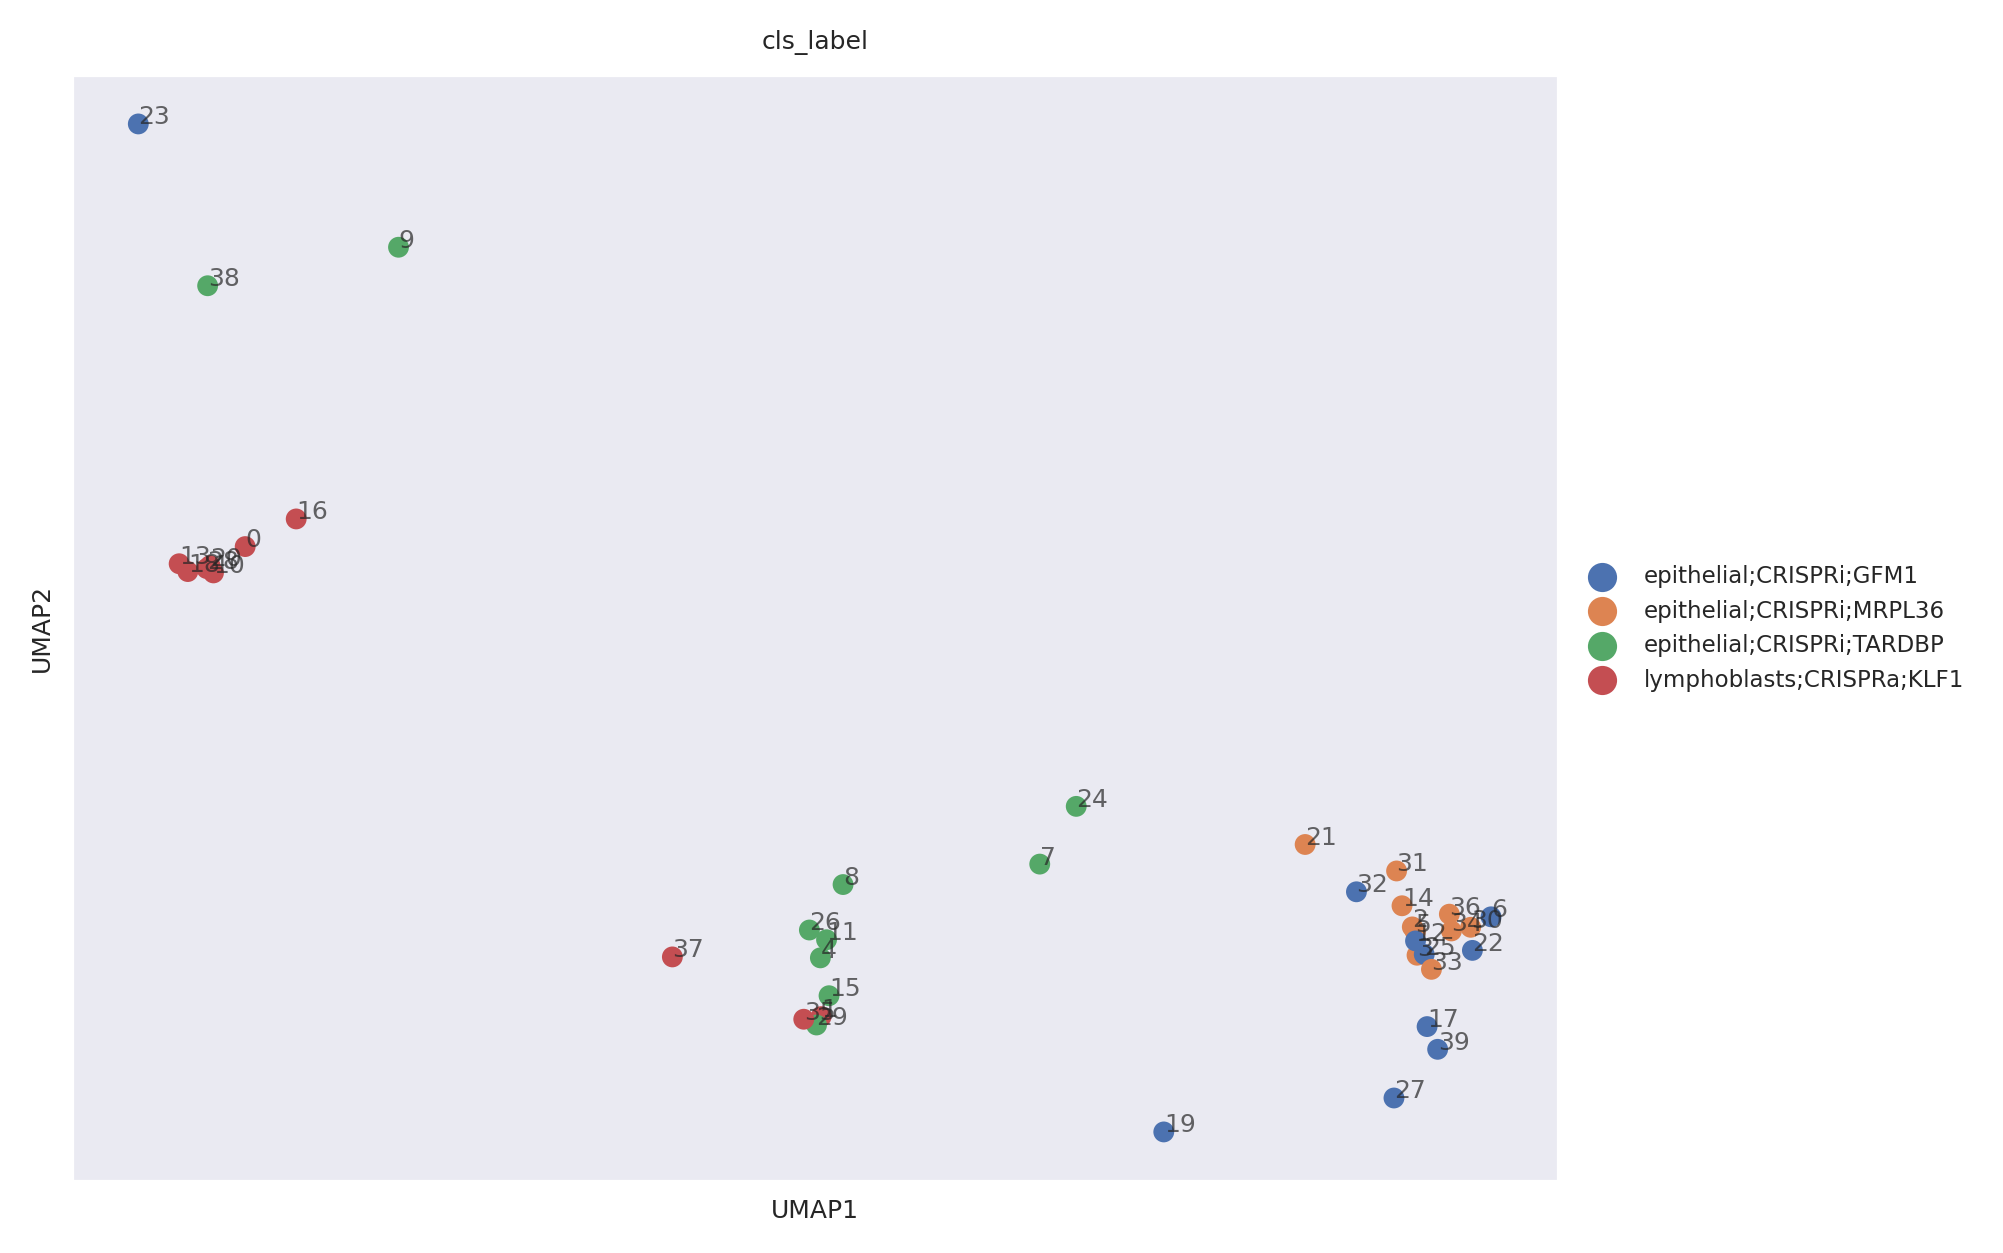

In [495]:
import matplotlib.pyplot as plt
import scanpy as sc

# Plot the UMAP, without showing it yet
sc.pl.umap(b_latent, color='cls_label', show=False, size=100)

# Now overlay text labels
for i, row in b_latent.obs.iterrows():
    coord = b_latent.obsm['X_umap'][b_latent.obs.index.get_loc(i)]
    plt.text(coord[0], coord[1], str(row['idx']), fontsize=6, alpha=0.7)
plt.gcf().set_dpi(300)
plt.show()

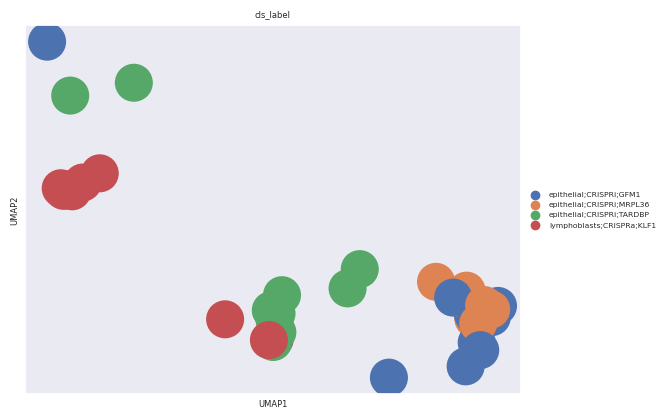

In [487]:
sc.pl.umap(b_latent, color='cls_label')

### Create cell-wise embedding

In [51]:
# Merge adata.obs with embedding map
adata_to_emb_idx = (
    adata.obs[['perturbation']]
    .reset_index(names='cell_idx')
    .merge(gene_emb_idx_map, left_on='perturbation', right_on='gene', how='left')
)
# Set perturbations that are not found to unknown, which is the last row in the map
adata_to_emb_idx.emb_idx.fillna(gene_emb_idx_map.index[-1], inplace=True)

In [52]:
# Add cell-specific gene embedding to .obsm for model to use
adata.obsm['gene_embedding'] = np.array(t_emb)[adata_to_emb_idx.emb_idx.astype(int)]
# Multiply by mixscsale score
adata.obsm['gene_embedding'] *= np.array(adata.obs['mixscale_score'])[:,np.newaxis]
# Convert to sparse matrix for training
adata.obsm['gene_embedding'] = sp.csr_matrix(adata.obsm['gene_embedding'])
adata.obsm['gene_embedding']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 200629248 stored elements and shape (263398, 1536)>

In [53]:
# Save adata
adata_o = os.path.join(os.path.dirname(adata_p), 'mixscale_filtered_w_emb.h5ad')
adata.write_h5ad(adata_o)

### Prepare training data

In [219]:
test = adata[adata.obs.perturbation.isin(adata.obs.perturbation.value_counts()[:10].index)].copy()
sc.pp.log1p(test)
sc.pp.scale(test)

In [220]:
# Define labels
ctrl_key = 'control'
cls_labels = np.array(['celltype', 'perturbation_type', 'perturbation'])

In [221]:
# Add control label
test.obs['is_ctrl'] = False
test.obs.loc[test.obs[cls_labels[-1]]==ctrl_key, 'is_ctrl'] = True

In [227]:
p_pos = -1
cls_range = np.arange(len(cls_labels))
mask = cls_range != cls_range[p_pos]
cls_labels_excl = np.array(cls_labels)[mask].tolist()

In [229]:
cls_labels_excl

['celltype', 'perturbation_type']

In [230]:
cpp = test.obs.groupby(cls_labels_excl, observed=True)['is_ctrl'].value_counts()

In [231]:
cpp

celltype                          perturbation_type  is_ctrl
lymphoblasts                      CRISPRi            True       83608
                                                     False       5278
retinal pigment epithelial cells  CRISPRi            True       11288
                                                     False       7929
Name: count, dtype: int64

In [232]:
# Get
idc = []
ctrl_idc = []
for group, data in test.obs[~test.obs.is_ctrl].groupby(cls_labels_excl, observed=True):
    mask = True
    idc.extend(data.index)
    print(group)
    for i, g in enumerate(group):
        mask &= test.obs[cls_labels[i]]==g
    print(np.sum(mask), 'total', n_p, 'group')
    n_p = cpp[*group, False]
    ctrl_idc.extend(test.obs[mask].sample(n_p).index)

('lymphoblasts', 'CRISPRi')
88886 total 7929 group
('retinal pigment epithelial cells', 'CRISPRi')
19217 total 5278 group


In [233]:
# Filter for perturbed cells and ensure correct order by groups
ctrl_layer = test[ctrl_idc].X

In [234]:
# Filter cells
test = test[idc].copy()
test.layers['B'] = ctrl_layer

In [92]:
# Check if we have enough control cells to draw every perturbation
n_ctrl_cells = cpp['control']
n_pert_cells = cpp[cpp.index!='control'].sum()
replace = n_ctrl_cells < n_pert_cells

In [99]:
# Randomly draw number of perturbed cells from control cells
x_b_cells = test.obs.sample(n_pert_cells, replace=replace).index

In [101]:
test[x_b_cells]

View of AnnData object with n_obs × n_vars = 13207 × 7079
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'perturbation', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'dataset', 'perturbation_type', 'exact_perturbation', 'is_ctrl', 'mixscale_score', 'NP', 'mixscale_mask'
    obsm: 'X_pca', 'gene_embedding'

In [26]:
# Simulate expression encoder with pca
sc.pp.pca(test, n_comps=10)

In [28]:
# Simulate embedding encoder with pca
test.obsm['g'] = sc.pp.pca(test.obsm['gene_embedding'], n_comps=10)

In [30]:
tensors = test.obsm

2025-04-17 10:45:04.973725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 10:45:06.271073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


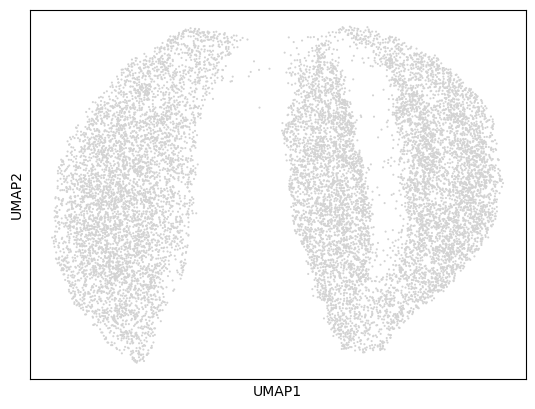

In [33]:
# Plot X latent
sc.pp.neighbors(test, use_rep='X_pca')
sc.tl.umap(test)
sc.pl.umap(test, color='perturbation')

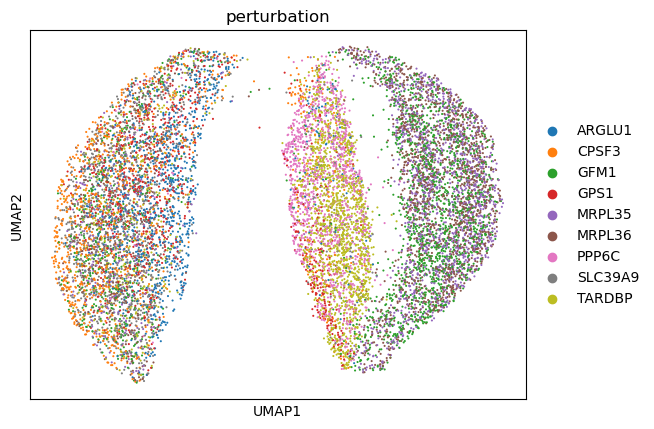

In [34]:
sc.pl.umap(test, color='perturbation')

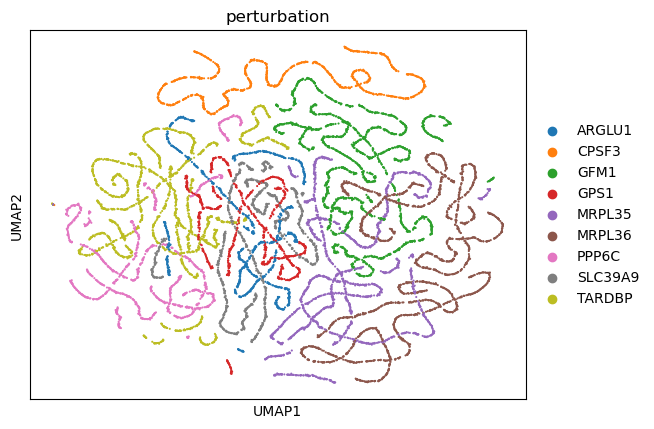

In [35]:
# Plot latent g
sc.pp.neighbors(test, use_rep='g')
sc.tl.umap(test)
sc.pl.umap(test, color='perturbation')

In [54]:
from scipy.stats import spearmanr

In [72]:
spc = spearmanr(test.obsm['g'], axis=0)

<Axes: >

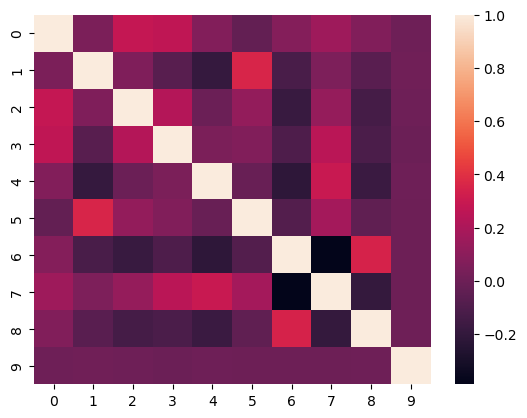

In [73]:
import seaborn as sns
sns.heatmap(spc.statistic)

In [47]:
test_g = sc.get.aggregate(test, by='perturbation', obsm='g', func='mean')
test_g.X = test_g.layers['mean']
test_g.obsm['X_pca'] = test_g.layers['mean']

In [42]:
sc.pp.neighbors(test_g, use_rep='X')

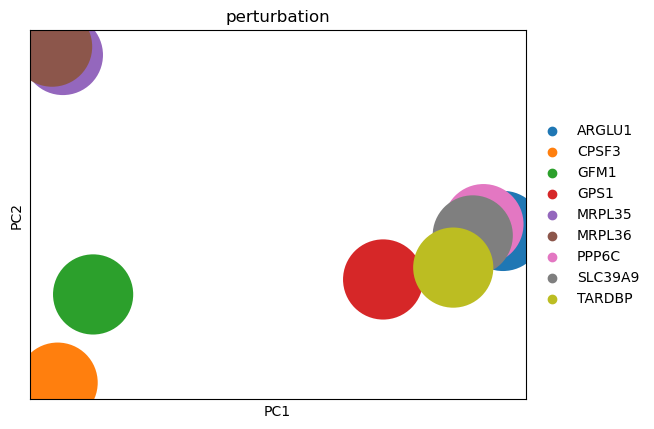

In [48]:
sc.pl.pca(test_g, color='perturbation')

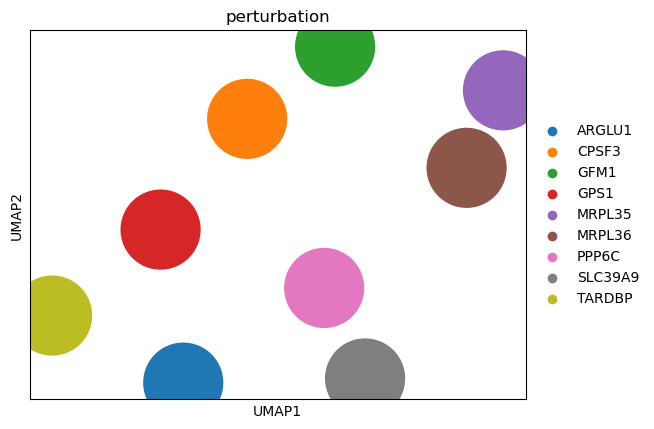

In [45]:
sc.tl.umap(test_g)
sc.pl.umap(test_g, color='perturbation')

### Create random signatures

<Axes: ylabel='Count'>

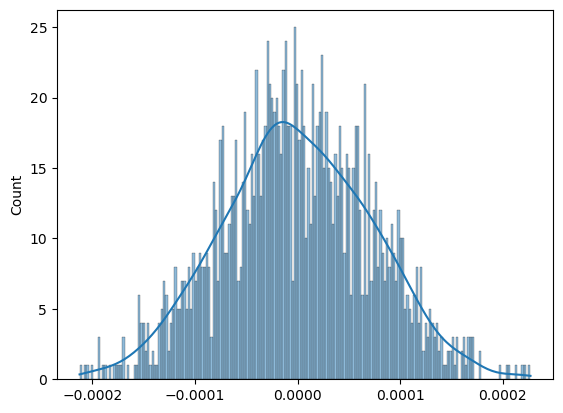

In [91]:
from scipy.stats import laplace

random_noise_embedding = laplace.rvs(loc=0, scale=0.03, size=adata.obsm['gene_embedding'].shape)

sns.histplot(random_noise_embedding.mean(axis=0), bins=200, kde=True)

In [1]:
t_emb

NameError: name 't_emb' is not defined

<Axes: ylabel='Count'>

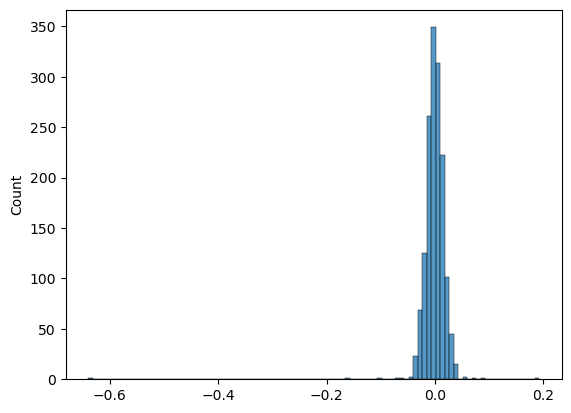

In [32]:
sns.histplot(t_emb.mean(axis=0), bins=100)

In [19]:
import anndata as ad

e_adata = ad.AnnData(X=t_emb, obs=pd.DataFrame(t_emb.index, columns=['gene'], index=t_emb.index))

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


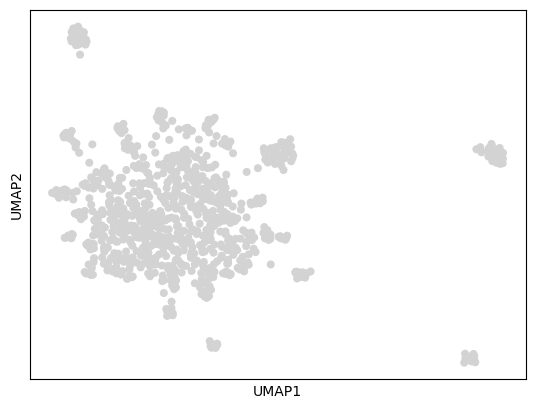

In [29]:
sc.pp.pca(e_adata)
sc.pp.neighbors(e_adata)
sc.tl.umap(e_adata)
sc.pl.umap(e_adata, legend_loc=None)

<Axes: ylabel='Count'>

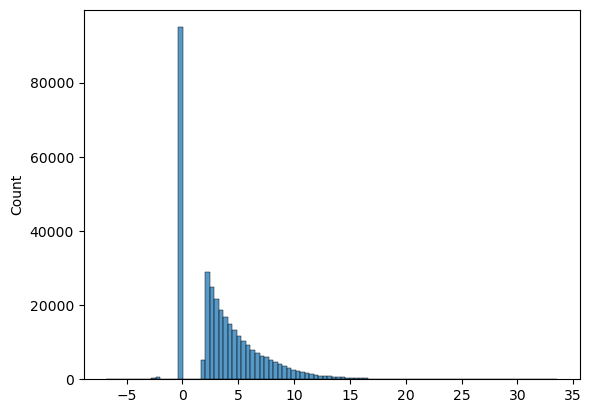

In [80]:
sns.histplot(adata.obs.mixscale_score.ravel(), bins=100)

<Axes: ylabel='Count'>

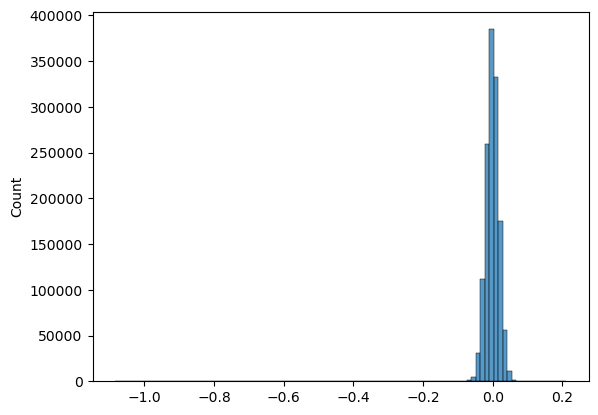

In [92]:
sns.histplot(np.log1p(np.array(t_emb).ravel()), bins=100)